<a href="https://colab.research.google.com/github/taylor-coleman/taylor-coleman.github.io/blob/master/DS_Sprint_Challenge_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_

# Applied Modeling Sprint Challenge: Predict Chicago food inspections 🍔

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to install packages in Colab:

In [1]:
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

     |████████████████████████████████| 102kB 3.1MB/s 
     |████████████████████████████████| 112kB 3.5MB/s 
     |████████████████████████████████| 133kB 3.5MB/s 
     |████████████████████████████████| 614kB 37.5MB/s 
     |████████████████████████████████| 235kB 21.4MB/s 
     |████████████████████████████████| 307kB 30.7MB/s 
     |████████████████████████████████| 51kB 14.5MB/s 
     |████████████████████████████████| 215kB 43.8MB/s 
     |████████████████████████████████| 51kB 19.7MB/s 
     |████████████████████████████████| 737kB 38.0MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-2.3.0-py2.py3-none-any.whl size=145035 sha256=b6d692c3b87ebf07173f6ee483fabcdb1cfae9666ad37dd2a278f5ace898ebcc
  Stored in directory: /root/.cache/pip/wheels/ce/c7/f1/dbfef4848ebb048cb1d4a22d1ed0c62d8ff2523747235e19fe
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp36-none-any.whl size=27084 sha256=9ed9338371234d13058f33b75458588b18cdc061a500669d6c21919db6bd1c01
  Stored 

#### Run this cell to load the data:

In [0]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:

- Permutation Importances
- Partial Dependence Plot, 1 feature isolation
- Partial Dependence Plot, 2 features interaction
- Shapley Values

_To earn a score of 3 for this part, make all four of these visualization types._

## Part 1: Preprocessing

> You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

In [128]:
train.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0
4,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0


In [129]:
train.isnull().sum()

Inspection ID         0
DBA Name              0
AKA Name            623
License #             5
Facility Type       224
Risk                 12
Address               0
City                 53
State                10
Zip                  26
Inspection Date       0
Inspection Type       1
Violations         9655
Latitude            198
Longitude           198
Location            198
Fail                  0
dtype: int64

In [0]:
def engineer_features(X):
    X = X.copy()
    
    X['Inspection Type'] = X['Inspection Type'].dropna()
    X['Facility Type'] = X['Facility Type'].dropna()
    X['Latitude'] = X['Latitude'].dropna()
    X['Longitude'] = X['Longitude'].dropna()
    X['Zip'] = X['Zip'].dropna()
    X['Fail'] = X['Fail'].dropna() 
  
  
    X = X.drop(columns=['Violations', 'DBA Name', 'License #', 'Location', 'City', 'State', 'AKA Name'])
    
    X['Inspection Date'] = pd.to_datetime(X['Inspection Date'], infer_datetime_format=True)
    
    return X

train = engineer_features(train)
test = wrangle(test)

In [131]:
print(train.shape)
train.head(5)

(51916, 10)


,Inspection ID,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Latitude,Longitude,Fail
0,2088270,Restaurant,Risk 1 (High),608 W BARRY,60657.0,2017-09-15,Canvass,41.938007,-87.644755,1
1,555268,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,60636.0,2011-10-20,Complaint Re-Inspection,41.772402,-87.683603,0
2,1751394,Restaurant,Risk 1 (High),2025 E 75TH ST,60649.0,2016-04-05,Canvass Re-Inspection,41.758779,-87.575054,0
3,1763905,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,60632.0,2016-04-29,Canvass,41.812181,-87.707125,0
4,453326,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,60629.0,2011-01-10,Canvass,NaN,NaN,0


In [132]:
from sklearn.model_selection import train_test_split

target = train['Fail']

X_trainval, X_test, y_trainval, y_test = train_test_split(
    train, target, train_size =0.8, test_size=0.2, stratify=target, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, train_size =0.8, test_size=0.2, 
    stratify=y_trainval, random_state=42)


print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_val shape', X_val.shape)
print('y_val shape', y_val.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

X_train shape (33225, 10)
y_train shape (33225,)
X_val shape (8307, 10)
y_val shape (8307,)
X_test shape (10384, 10)
y_test shape (10384,)


In [133]:
y_train.value_counts(normalize=True)

0    0.741369
1    0.258631
Name: Fail, dtype: float64

## Part 2: Modeling

> **Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.
>
> Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

In [0]:
# I was getting 1 for ROC AUC score
def edit(X):
    
    X = X.copy()
    
    X = X.drop(columns='Inspection Date')
    
    X = X.drop(columns='Fail')
    
    return X
    
X_train = edit(X_train)
X_val   = edit(X_val)
X_test  = edit(X_test)

In [0]:
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

model = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42)
)

model.fit(X_train, y_train);

In [144]:
model.named_steps

{'ordinalencoder': OrdinalEncoder(cols=['Facility Type', 'Risk', 'Address', 'Inspection Type'],
                drop_invariant=False, handle_missing='value',
                handle_unknown='value',
                mapping=[{'col': 'Facility Type', 'data_type': dtype('O'),
                          'mapping': Restaurant                                    1
 School                                        2
 Grocery Store                                 3
 Liquor                                        4
 Daycare Above and Under 2 Years               5
 Mobile Food Dispenser                         6
 Daycare (2 - 6 Years)                         7
 Hospital                                      8
 Catering                                      9
 Long Term Care                               10
 NaN                                          11
 Bakery                                       12...
 Package Liquor 1474                       24
 CANVASS SPECIAL EVENTS                    25
 LICENSE

In [151]:
from sklearn.metrics import roc_auc_score

rf_y_pred = rf.predict(X_val)
roc_auc_score(y_val, rf_y_pred)

0.5968818851641917

In [152]:
rf_y_pred_proba = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, rf_y_pred_proba)

0.7099204643066739

In [0]:
from xgboost import XGBClassifier

xgb = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'),
    XGBClassifier(n_estimators=1000, n_jobs=-1)
)

xgb.fit(X_train, y_train);

In [153]:
xgb_y_pred = xgb.predict(X_val)
roc_auc_score(y_val, xgb_y_pred)

0.5735350275429244

In [154]:
xgb_y_pred_proba = xgb.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, xgb_y_pred_proba)

0.7224563574886851

## Part 3: Visualization

> Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:
>
> - Permutation Importances
> - Partial Dependence Plot, 1 feature isolation
> - Partial Dependence Plot, 2 features interaction
> - Shapley Values

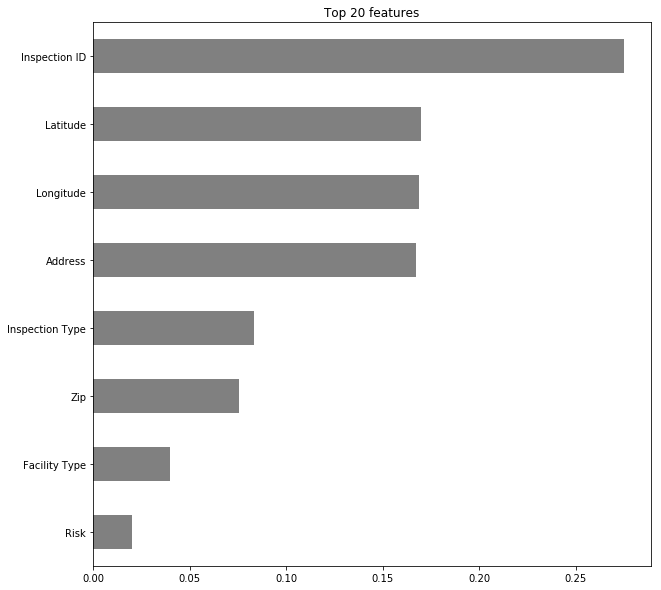

In [156]:
import matplotlib.pyplot as plt
%matplotlib inline

rf = model.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)


n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [158]:
transformers = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy="median")
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.fit_transform(X_val)

model = XGBClassifier(n_estimators=1000, n_jobs=-1)
model.fit(X_train_transformed, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [159]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model,
    scoring='accuracy',
    n_iter=2,
    random_state=42
)

permuter.fit(X_val_transformed, y_val)
feature_names = X_val.columns.tolist()

eli5.show_weights(
    permuter,
    top=None,
    feature_names = feature_names
)

Weight,Feature
0.0356 ± 0.0055,Inspection Type
0.0222 ± 0.0011,Inspection ID
0.0072 ± 0.0013,Latitude
0.0034 ± 0.0004,Longitude
0.0031 ± 0.0006,Zip
0.0029 ± 0.0012,Facility Type
-0.0002 ± 0.0012,Risk
-0.0029 ± 0.0012,Address
